In [2]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [3]:
data = pd.read_csv('dog_label3.csv')

In [4]:
image_paths = ['./output_images3/' + filename for filename in data['title'].values]  # 'output_images' 폴더 안에 있는 이미지 파일 경로  # 이미지 파일 경로 컬럼 이름
labels = data[['face','lying_position','not_highlight']].values  # 라벨 컬럼 이름

In [5]:
# 이미지 전처리 및 데이터 구성
image_data = []
for image_path in image_paths:
    img = load_img(image_path, target_size=(150, 150))  # 이미지 로드 및 크기 조정 (예: 150x150)
    img_array = img_to_array(img) / 255.0  # 이미지를 배열로 변환하고 정규화
    image_data.append(img_array)

X = np.array(image_data)  # 이미지 데이터를 넘파이 배열로 변환
y = np.array(labels)  # 라벨 데이터를 넘파이 배열로 변환

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 데이터 증강을 위한 설정
datagen = ImageDataGenerator(
    rotation_range=20,  # 랜덤하게 이미지 회전 (0~20도 사이)
    width_shift_range=0.1,  # 가로 방향으로 랜덤 이동
    height_shift_range=0.1,  # 세로 방향으로 랜덤 이동
    shear_range=0.2,  # 전단 변환
    zoom_range=0.2,  # 랜덤 확대/축소
    horizontal_flip=True,  # 수평 방향 뒤집기
    fill_mode='nearest'  # 이미지를 회전 또는 이동할 때 채울 픽셀
)

# 학습 데이터에 데이터 증강을 적용하고 증강된 이미지를 생성
augmented_data = []
for img in X_train:
    img = img.reshape((1,) + img.shape)  # 이미지를 4D 텐서로 변환 (batch 차원 추가)
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_data.append(batch[0])
        i += 1
        if i >= 3:  # 증강된 이미지 수를 조절할 수 있습니다. 여기서는 각 이미지당 3개의 변형을 생성합니다.
            break

# 증강된 이미지 데이터를 합쳐서 기존 학습 데이터에 추가
X_train_augmented = np.array(augmented_data)
y_train_augmented = np.array([label for label in y_train for _ in range(3)])  # 라벨도 증강된 이미지에 맞게 복제

# 증강된 데이터를 기존 학습 데이터에 추가
X_train = np.concatenate((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

# 데이터 증강 후 학습 데이터와 테스트 데이터로 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

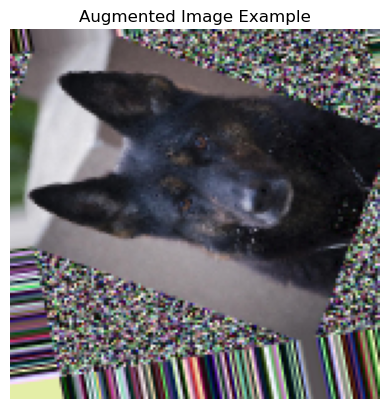

In [8]:
import matplotlib.pyplot as plt

# 첫 번째 증강된 이미지 시각화
plt.imshow(X_train_augmented[0])
plt.axis('off')  # 이미지 축 제거
plt.title('Augmented Image Example')
plt.show()


In [6]:
# CNN 모델 구축
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3개의 노드 - 3가지 라벨

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
168/168 [==============================] - 58s 337ms/step - loss: 1.0397 - accuracy: 0.4867 - val_loss: 0.8880 - val_accuracy: 0.5981
Epoch 2/10
168/168 [==============================] - 54s 320ms/step - loss: 0.7846 - accuracy: 0.6493 - val_loss: 1.0230 - val_accuracy: 0.5694
Epoch 3/10
168/168 [==============================] - 56s 335ms/step - loss: 0.6291 - accuracy: 0.7307 - val_loss: 0.7645 - val_accuracy: 0.6603
Epoch 4/10
168/168 [==============================] - 65s 384ms/step - loss: 0.4510 - accuracy: 0.8161 - val_loss: 0.7199 - val_accuracy: 0.7464
Epoch 5/10
168/168 [==============================] - 61s 365ms/step - loss: 0.2483 - accuracy: 0.9054 - val_loss: 0.8807 - val_accuracy: 0.7608
Epoch 6/10
168/168 [==============================] - 56s 336ms/step - loss: 0.1306 - accuracy: 0.9553 - val_loss: 1.0738 - val_accuracy: 0.7679
Epoch 7/10
168/168 [==============================] - 56s 331ms/step - loss: 0.0573 - accuracy: 0.9824 - val_loss: 1.3124 - val_ac

In [7]:
# 모델 평가 
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

14/14 [==============================] - 1s 90ms/step - loss: 1.6704 - accuracy: 0.7416
Test accuracy: 0.7416267991065979


In [15]:
# CNN 모델 구축 epoch 20
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3개의 노드 - 3가지 라벨

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
168/168 [==============================] - 55s 324ms/step - loss: 1.0174 - accuracy: 0.4892 - val_loss: 0.9476 - val_accuracy: 0.5526
Epoch 2/20
168/168 [==============================] - 54s 321ms/step - loss: 0.8356 - accuracy: 0.6146 - val_loss: 0.8807 - val_accuracy: 0.6100
Epoch 3/20
168/168 [==============================] - 53s 314ms/step - loss: 0.6913 - accuracy: 0.6987 - val_loss: 0.8193 - val_accuracy: 0.6699
Epoch 4/20
168/168 [==============================] - 53s 316ms/step - loss: 0.5441 - accuracy: 0.7768 - val_loss: 0.8006 - val_accuracy: 0.6866
Epoch 5/20
168/168 [==============================] - 55s 329ms/step - loss: 0.3785 - accuracy: 0.8503 - val_loss: 0.9039 - val_accuracy: 0.6890
Epoch 6/20
168/168 [==============================] - 57s 342ms/step - loss: 0.2122 - accuracy: 0.9241 - val_loss: 0.8677 - val_accuracy: 0.7297
Epoch 7/20
168/168 [==============================] - 53s 318ms/step - loss: 0.0933 - accuracy: 0.9733 - val_loss: 1.2535 - val_ac

In [16]:
# 모델 평가 
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

14/14 [==============================] - 1s 54ms/step - loss: 2.1142 - accuracy: 0.7608
Test accuracy: 0.760765552520752


In [9]:
# CNN 모델 구축 epoch 20
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3개의 노드 - 3가지 라벨

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
168/168 [==============================] - 38s 221ms/step - loss: 1.0559 - accuracy: 0.4721 - val_loss: 0.9807 - val_accuracy: 0.5335
Epoch 2/30
168/168 [==============================] - 37s 223ms/step - loss: 0.8453 - accuracy: 0.6168 - val_loss: 1.0537 - val_accuracy: 0.5359
Epoch 3/30
168/168 [==============================] - 39s 230ms/step - loss: 0.6886 - accuracy: 0.6970 - val_loss: 0.8084 - val_accuracy: 0.6531
Epoch 4/30
168/168 [==============================] - 38s 228ms/step - loss: 0.5127 - accuracy: 0.7983 - val_loss: 0.7821 - val_accuracy: 0.6818
Epoch 5/30
168/168 [==============================] - 38s 227ms/step - loss: 0.3215 - accuracy: 0.8778 - val_loss: 0.9851 - val_accuracy: 0.6986
Epoch 6/30
168/168 [==============================] - 40s 240ms/step - loss: 0.1755 - accuracy: 0.9351 - val_loss: 1.4227 - val_accuracy: 0.6842
Epoch 7/30
168/168 [==============================] - 42s 252ms/step - loss: 0.1086 - accuracy: 0.9632 - val_loss: 1.6384 - val_ac

In [10]:
# 모델 평가 
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

14/14 [==============================] - 1s 43ms/step - loss: 3.4533 - accuracy: 0.7201
Test accuracy: 0.720095694065094


In [13]:
#드롭아웃 추가
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # 첫 번째 Dropout 레이어 추가

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # 두 번째 Dropout 레이어 추가

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))  # 세 번째 Dropout 레이어 추가

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # 네 번째 Dropout 레이어 추가

model.add(Dense(3, activation='softmax'))  # 3개의 노드 - 3가지 라벨

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
168/168 [==============================] - 77s 453ms/step - loss: 1.1736 - accuracy: 0.4097 - val_loss: 1.0499 - val_accuracy: 0.4641
Epoch 2/10
168/168 [==============================] - 73s 436ms/step - loss: 0.9638 - accuracy: 0.5520 - val_loss: 0.8948 - val_accuracy: 0.5861
Epoch 3/10
168/168 [==============================] - 74s 440ms/step - loss: 0.8920 - accuracy: 0.5912 - val_loss: 0.8892 - val_accuracy: 0.6100
Epoch 4/10
168/168 [==============================] - 74s 439ms/step - loss: 0.8291 - accuracy: 0.6290 - val_loss: 0.8844 - val_accuracy: 0.6148
Epoch 5/10
168/168 [==============================] - 74s 439ms/step - loss: 0.7617 - accuracy: 0.6735 - val_loss: 0.8084 - val_accuracy: 0.6507
Epoch 6/10
168/168 [==============================] - 72s 428ms/step - loss: 0.7288 - accuracy: 0.6856 - val_loss: 0.8364 - val_accuracy: 0.6316
Epoch 7/10
168/168 [==============================] - 74s 439ms/step - loss: 0.6617 - accuracy: 0.7144 - val_loss: 0.7603 - val_ac

In [14]:
# 모델 평가 
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

14/14 [==============================] - 1s 82ms/step - loss: 0.7281 - accuracy: 0.7057
Test accuracy: 0.7057416439056396


In [19]:
# model 저장
model.save('my_trained_model_2.h5')

In [18]:
# 이미지를 모델에 입력하여 예측하기
from tensorflow.keras.preprocessing import image
import numpy as np

# 이미지 불러오기
img_path = './output_images2/dog3.jpg'  # 사용할 이미지 경로를 지정하세요
img = image.load_img(img_path, target_size=(150, 150))  # 이미지를 로드하고 크기를 조정합니다.
img_array = image.img_to_array(img)  # 이미지를 배열로 변환합니다.
img_array = np.expand_dims(img_array, axis=0)  # 배치 차원을 추가합니다.

# 모델에 입력하기 전에 이미지 전처리 수행
img_array = img_array / 255.0  # 이미지를 0과 1 사이 값으로 스케일링합니다.

# 모델에 이미지 입력하여 예측하기
prediction = model.predict(img_array)
print(prediction)  # 각 클래스에 대한 확률을 출력합니다.

# 예측 결과 해석
class_names = ['face', 'lying', 'not_highlight']  # 클래스 이름을 지정하세요
predicted_class = np.argmax(prediction, axis=1)
print(f'Predicted class: {class_names[predicted_class[0]]}')  # 예측된 클래스를 출력합니다.


1/1 [==============================] - 0s 27ms/step
[[1.000000e+00 7.002109e-14 9.922569e-10]]
Predicted class: face
